# Testing of the wedge

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quadrature
import tensorflow as tf

In [4]:
def read_cbin(filename, bits=32, order='C', dimensions=3, records=False):
        ''' Read a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to read from
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                * dimensions (int): the number of dimensions of the data (default:3)
                * records (boolean): does the file contain record separators?
                        
        Returns:
                The data as a N dimensional numpy array.
        
        Example:
                > data = read_cbin(filename='nsrc_z6.981.dat')

        '''

        assert(bits ==32 or bits==64)

        f = open(filename)

        #print('Reading cbin file: %s' % filename)

        counter = dimensions+3 if records else dimensions
        header = np.fromfile(f, count=counter, dtype='int32')
        if records: temp_mesh=header[1:4]
        else: temp_mesh=header[0:3]

        datatype = np.float32 if bits == 32 else np.float64
        data = np.fromfile(f, dtype=datatype, count=np.prod(temp_mesh))
        data = data.reshape(temp_mesh, order=order)
        f.close()
        return data

def save_cbin(filename, data, bits=32, order='C'):
        ''' Save a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to save to
                * data (numpy array): the data to save
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                        
        Returns:
                Nothing
        '''
        #print('Saving cbin file: %s' % filename)
        assert(bits ==32 or bits==64)
        f = open(filename, 'wb')
        mesh = np.array(data.shape).astype('int32')
        mesh.tofile(f)
        datatype = (np.float32 if bits==32 else np.float64)
        data.flatten(order=order).astype(datatype).tofile(f)
        f.close()

# Tensorflow version
The difference between previous versions is that I allowed for all of the constant calculations to be computed in advance and saved on the GPU, and then one can iterate over the whole dataset

In [5]:
def one_over_E(z, OMm):
    return 1 / np.sqrt(OMm * (1.0 + z) ** 3 + (1 - OMm))

def multiplicative_factor(z, OMm):
    return (1 / one_over_E(z, OMm) / (1 + z) * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0])

def calculate_k_cube(HII_DIM, chunk_length, cell_size):
    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k_parallel = np.fft.fftfreq(chunk_length, d=cell_size)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = np.meshgrid(k, k, k_parallel)
    return tf.constant(k_cube, dtype = tf.float32), tf.constant(delta_k, dtype = tf.float32)

def calculate_blackman(chunk_length, delta_k):
    bm = np.abs(np.fft.fft(np.blackman(chunk_length))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= 1e-10)[0][0] - 1)
    BM = np.blackman(chunk_length)[np.newaxis, np.newaxis, :]
    return tf.constant(BM, dtype = tf.complex64), tf.constant(buffer, dtype = tf.float32)

def wedge_removal_tf(
    OMm,
    redshifts,
    HII_DIM,
    cell_size,
    Box,
    chunk_length=501,
    blackman=True,
    MF = None,
    k_cube_data = None,
    blackman_data = None,
    
):
    # here we allow to pass multiplicative factor, k_cube_data, blackman_data, just so that it is not constantly re-computed
    
    permute = [2, 0, 1]
    inverse_permute = [1, 2, 0]
    
    if chunk_length % 2 == 0:
        chunk_length += 1
    
    if MF is None:
        MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
    # Box = tf.constant(Box, dtype = tf.float32)
    Box_uv = tf.transpose(tf.cast(Box, tf.complex64), perm = permute)
    Box_uv = tf.signal.fft2d(Box_uv)
    Box_uv = tf.transpose(Box_uv, perm = inverse_permute)

    if k_cube_data is None:
        k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
    else:
        k_cube, delta_k = k_cube_data

    if blackman_data is None:
        BM, buffer = calculate_blackman(chunk_length, delta_k) 
    else:
        BM, buffer = blackman_data

    box_shape = Box_uv.shape
    # Box_final = np.empty(box_shape, dtype=np.float32)
    Box_final = []
    empty_box = tf.zeros(k_cube[0].shape, dtype = tf.complex64)
    Box_uv = tf.concat([empty_box, Box_uv, empty_box], axis=2)

    for i in range(chunk_length, box_shape[-1] + chunk_length):
        t_box = Box_uv[..., i - chunk_length // 2 : i + chunk_length // 2 + 1]
        W = k_cube[2] / (
            tf.math.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2)
            * MF[tf.math.minimum(i - chunk_length // 2 - 1, box_shape[-1] - 1)]
            + buffer
        )
        w = tf.cast(tf.math.logical_or(W < -1.0, W > 1.0), tf.complex64)
        # w = cp.array(W[i + chunk_length - 1])
        if blackman is True:
            t_box = t_box * BM
        Box_final.append(
            tf.math.real(tf.signal.ifft3d(tf.signal.fft(t_box) * w)[..., chunk_length // 2])
        )

    return tf.transpose(tf.convert_to_tensor(Box_final), perm = inverse_permute).numpy()


In [6]:
path_out = '/scratch/snx3000/mibianco/test_wedge/'
path_input = '/store/ska/sk09/test_wedge/'

dT = read_cbin(path_input+'dT_21cm.bin')
dT2 = read_cbin(path_input+'dT2_21cm.bin')
dT3 = read_cbin(path_input+'dT3_21cm.bin')
dT3gf = read_cbin(path_input+'dT3gf_21cm.bin')
dT3exgf = read_cbin(path_input+'dT3exgf_21cm.bin')

dTf = read_cbin(path_input+'dT3f_21cm.bin')
dTfn = read_cbin(path_input+'dT3fn_21cm.bin')
xHI = read_cbin(path_input+'xHI_21cm.bin')
mask_xH = read_cbin(path_input+'xH_21cm.bin')
redshifts = np.loadtxt(path_input+'lc_redshifts.txt')

Once this is pre-computed, we have everything ready to be applied on the full dataset.
The way we would proceed for the whole dataset would be something like this:
```
dataset = []
for f in filenames:
    dataset.append(load_data(f))

dataset_W = []
for data in dataset:
    Box = tf.constant(data, dtype = tf.float32)
    data_W_tf = wedge_removal_tf(
        OMm,
        redshifts,
        HII_DIM,
        cell_size,
        Box,
        chunk_length,
        blackman = True,
        MF = MF,
        k_cube_data = (k_cube, delta_k),
        blackman_data = (BM, buffer)
    )
    dataset_W.append(data_W_tf)
```

dT3


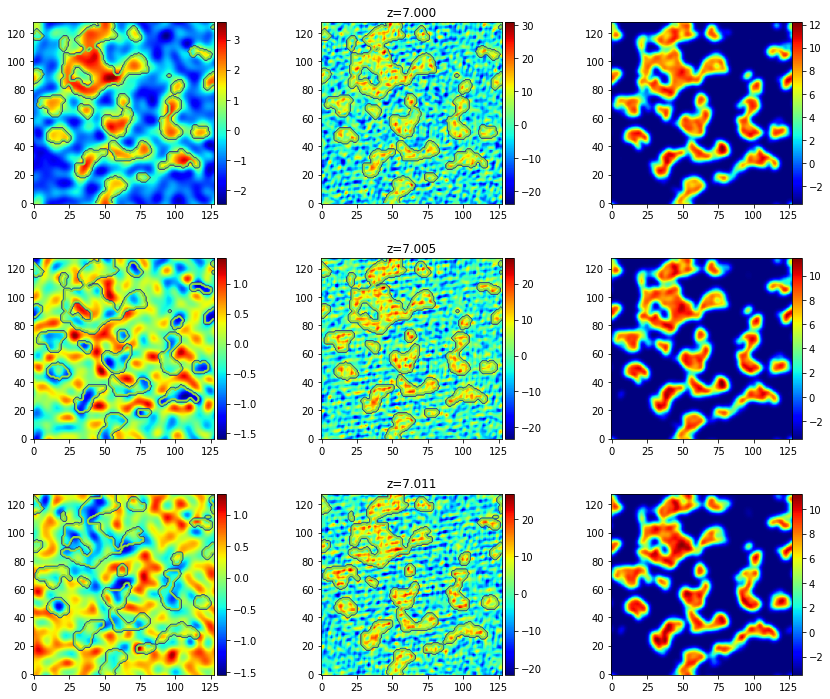

dT3gf


<Figure size 432x288 with 0 Axes>

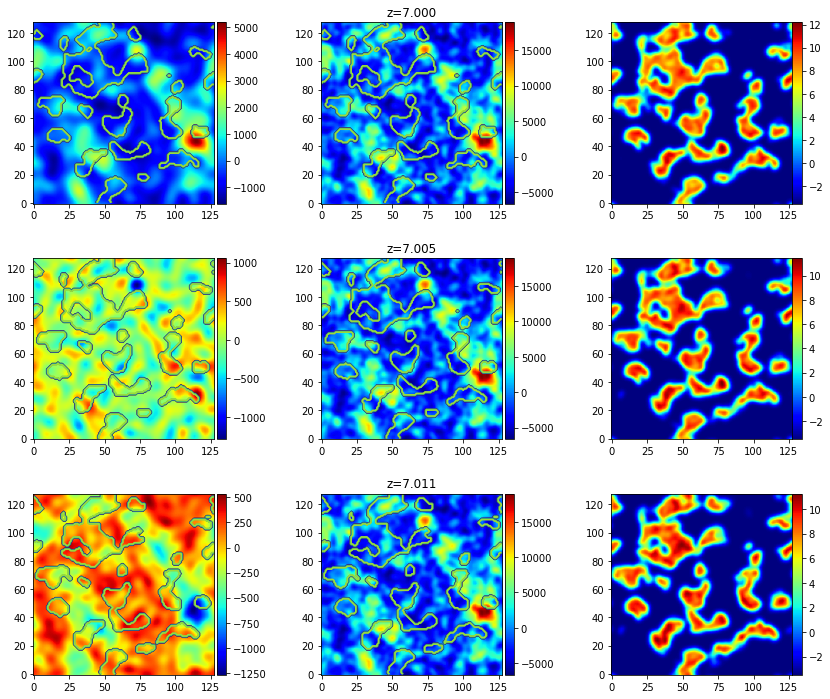

dT3exgf


<Figure size 432x288 with 0 Axes>

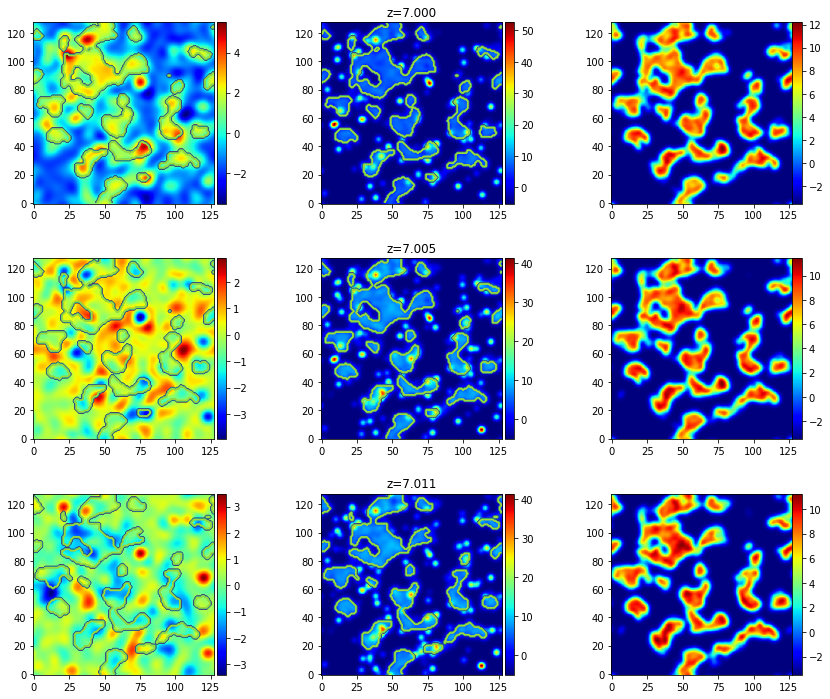

dTfn


<Figure size 432x288 with 0 Axes>

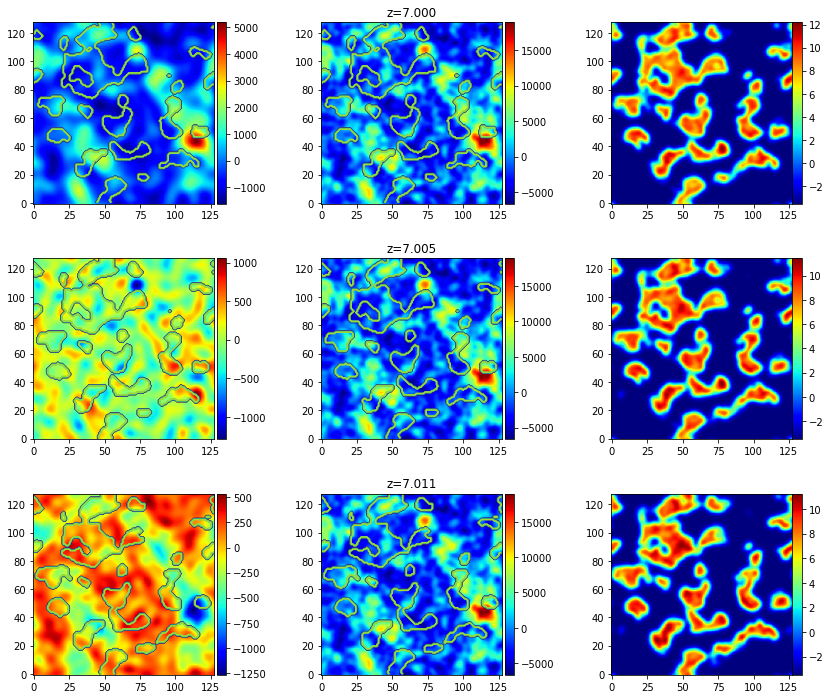

<Figure size 432x288 with 0 Axes>

In [8]:
OMm = 0.27
HII_DIM = 128
chunk_length = 129
cell_size = 2.0

MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
BM, buffer = calculate_blackman(chunk_length, delta_k)

var_arr = ['dT3', 'dT3gf', 'dT3exgf', 'dTfn']
#arr_plot = [np.argmin(np.abs(redshifts - search_z)) for search_z in [7, 8, 10]]
arr_plot = [0, 1, 2]

for var in var_arr:
    if(var == 'dT3'):
        data = dT3
    elif(var == 'dT3gf'):
        data = dT3gf
    elif(var == 'dT3exgf'):
        data = dT3exgf
    elif(var == 'dTfn'):
        data = dTfn
    
    Box = tf.constant(data, dtype = tf.float32)
    data_W_tf = wedge_removal_tf(OMm, redshifts, HII_DIM, cell_size, Box, chunk_length, blackman=True, MF=MF, k_cube_data=(k_cube, delta_k), blackman_data=(BM, buffer))
    np.save('%swdg_21cm.npy' %(path_out+var), data_W_tf)
    
    fig, axs = plt.subplots(3, 3, figsize=(15,12), facecolor='white')

    for i, i_plot in enumerate(arr_plot):
        ax1, ax2, ax3 = axs[i]
        #ax1.set_title('wedgeTF data')
        im = ax1.imshow(data_W_tf[..., i_plot], origin='lower', cmap='jet')
        ax1.contour(mask_xH[..., i_plot])
        plt.colorbar(im, ax=ax1, pad=0.01, fraction=0.048)
        ax2.set_title('z=%.3f' %redshifts[i_plot])
        #ax2.set_title('data')
        ax2.contour(mask_xH[..., i_plot])
        im = ax2.imshow(data[..., i_plot], origin='lower', cmap='jet')
        plt.colorbar(im, ax=ax2, pad=0.01, fraction=0.048)
        im = ax3.imshow(dT2[..., i_plot], origin='lower', cmap='jet')
        #ax3.set_title('dT2')
        plt.colorbar(im, ax=ax3, pad=0.0, fraction=0.048)
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.savefig('%swedge_comparison_%s.png' %(path_out, var), bbox_inches='tight')
    print(var)
    plt.show()
    plt.clf()